# Minilab 7 - SF Taxi fare prediction

In this minilab we will use exploratory analysis and [linear regression](https://en.wikipedia.org/wiki/Linear_regression) to build preedictive models from data. We will make predictions of taxi fares in SF. 

The dataset is San Francisco Taxi data from 9/1/2012 to 9/17/2012. The dataset consists of 50,000 taxi trips taken in the Bay Area during that time period. For each trip we are given the departure time, arrival time, passenger fare, departure lat/lon coordinates, arrival lat/lon coordinates, departure taz and arrival taz. 

In [1]:
from datascience import *
import datetime
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

# Part 1: exploratory analysis and visualization

In [2]:
sf_taxi = Table.read_table('data/SF_taxi_data.csv')
sf_taxi

id,departure time,arrival time,fare ($),num,dep lon,dep lat,arr lon,arr lat,deptaz,arrtaz,dist (miles)
0,9/1/12 0:11,9/1/12 0:20,13.2,1,-122.414,37.8027,-122.421,37.7854,38,30,1.98084
1,9/1/12 0:23,9/1/12 0:31,10.65,1,-122.42,37.7861,-122.435,37.7622,30,94,2.40224
2,9/1/12 0:45,9/1/12 0:49,9,1,-122.415,37.7747,-122.408,37.7826,10,11,0.479348
3,9/1/12 0:41,9/1/12 0:54,13.95,2,-122.419,37.8066,-122.415,37.7781,40,10,2.12241
4,9/1/12 1:09,9/1/12 1:13,7.35,1,-122.43,37.7978,-122.418,37.789,45,32,1.03807
5,9/1/12 1:40,9/1/12 1:52,11.75,1,-122.433,37.7841,-122.411,37.787,77,7,0.960851
6,9/1/12 2:49,9/1/12 2:51,5.15,1,-122.409,37.7856,-122.412,37.791,7,29,0.414315
7,9/1/12 3:29,9/1/12 3:47,43.65,1,-122.403,37.7927,-122.386,37.6181,2,239,14.5105
8,9/1/12 0:33,9/1/12 0:57,46.75,1,-122.387,37.6174,-122.407,37.7889,239,5,14.2747
9,9/1/12 4:39,9/1/12 4:43,6.25,1,-122.422,37.7977,-122.418,37.789,34,31,0.685312


### Computing Trip Duration
We can write our own methods to help process the data. For example we can create a method to compute trip duration. First we have to convert the departure time and arrival time into a timestamp, then we can compute the difference. Finally we convert it to minutes. It is done with the get_dur() function below.

In [3]:
def get_dur(start,finish): 
    start_time = datetime.datetime.strptime(start, "%m/%d/%y %H:%M")
    end_time = datetime.datetime.strptime(finish, "%m/%d/%y %H:%M")
    return (end_time-start_time).seconds/60.

We will use the [.apply](http://data8.org/datascience/_autosummary/datascience.tables.Table.apply.html#datascience.tables.Table.apply) method to create a 'trip duration (min)' column in the sf_taxi table.

In [6]:
sf_taxi["duration (min)"] = sf_taxi.apply(lambda start, finish: get_dur(start, finish), ["departure time", "arrival time"])

### More time variables
Similarly, we would like to create some other time variables that make it easier to manipulate with data. 

In [7]:
def get_hour(s): 
    return datetime.datetime.strptime(s, "%m/%d/%y %H:%M").hour

def get_date(s): 
    return datetime.datetime.strptime(s, "%m/%d/%y %H:%M").date()

def get_weekday(s): # 0 = Monday - 6= Sunday
    return datetime.datetime.strptime(s, "%m/%d/%y %H:%M").date().weekday()

In [8]:
sf_taxi['start hour'] = sf_taxi.apply(get_hour, "departure time")
sf_taxi['date'] = sf_taxi.apply(get_date, "departure time")
sf_taxi['day of week'] = sf_taxi.apply(get_weekday, "departure time")

## Trip fares exploration

SFMTA fare calculation table states that the fare for a trip of *x* miles will be at least 3.5 + 0.55 * (5x-1). Let us first explore the fare variable by plotting a histogram, and let's create a function to compute this base fare.

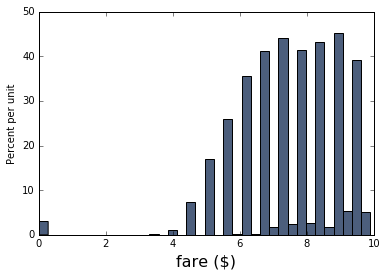

In [9]:
def base_fare(d):
    # 3.5 + 0.55*(5*d - 1), considering only completed 1/5-th miles (hence np.modf()[1])
    return ( 3.5 + 0.55* (np.modf(5*d)[1] - 1) )

# the histogram of trip fares
sf_taxi.select('fare ($)').hist(bins=np.arange(0,10,0.275))

### Visualize fares data
We are going to explore the dependence between the fare variable for the single-pax trips and the distance travelled. We will see how the actual fare paid relate to the base fare computed with a formula. Finally, we will highlight the trips from/to SFO with a different color.

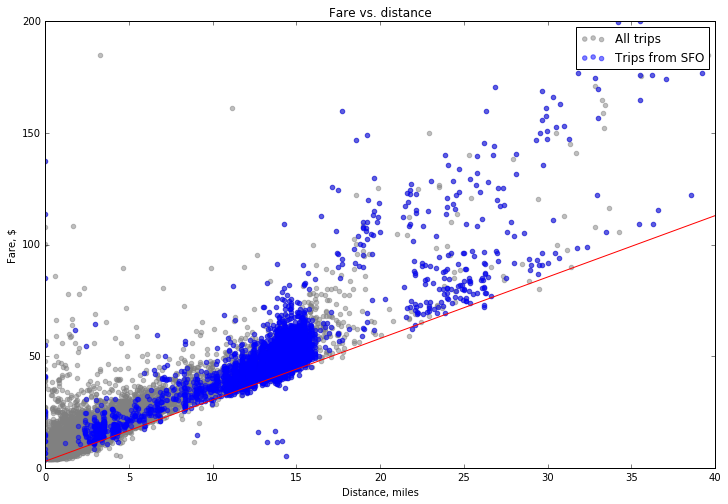

In [8]:
# one pax trips only
sf_taxi = sf_taxi.where(sf_taxi["num"]==1)
# fares <3.5 are likely to be errors
sf_taxi = sf_taxi.where(sf_taxi["fare ($)"]>3.5)
  
plt.figure(figsize = (12,8))

# plot fares for all trips
x, y=  sf_taxi.column("dist (miles)"), sf_taxi.column("fare ($)")
plt.scatter(x,y,color='grey', alpha = .5, label='All trips')

# plot fars for trips from SFO
sfo = sf_taxi.where( (sf_taxi.column("deptaz")==239) | (sf_taxi.column("arrtaz")==239))
x, y=  sfo.column("dist (miles)"), sfo.column("fare ($)")
plt.scatter(x,y,color='blue', alpha = .5, label='Trips from SFO')

# plot the lower bound of the fare, i.e. the official formula
plt.plot([0, 40], [base_fare(0), base_fare(40)], 'red')

plt.title('Fare vs. distance')
plt.xlabel('Distance, miles')
plt.ylabel('Fare, $')
plt.ylim([0,200])
plt.xlim([0,40])
plt.legend()

## Non-SFO trips within 15 miles

Let us narrow it down to the non-SFO trips of 0.1<d<15 miles duration.

In [9]:
nsfo_taxi = sf_taxi.where( (sf_taxi["deptaz"] != 239) & (sf_taxi["arrtaz"] != 239) )
# Keep only trips shorter than 15 miles, and longer than 0.1
nsfo_taxi = nsfo_taxi.where(nsfo_taxi["dist (miles)"] < 15)
nsfo_taxi = nsfo_taxi.where(nsfo_taxi["dist (miles)"] > 0.1)

nsfo_taxi

id,departure time,arrival time,fare ($),num,dep lon,dep lat,arr lon,arr lat,deptaz,arrtaz,dist (miles),duration (min),start hour,date,day of week
0,9/1/12 0:11,9/1/12 0:20,13.2,1,-122.414,37.8027,-122.421,37.7854,38,30,1.98084,9,0,2012-09-01,5
1,9/1/12 0:23,9/1/12 0:31,10.65,1,-122.42,37.7861,-122.435,37.7622,30,94,2.40224,8,0,2012-09-01,5
2,9/1/12 0:45,9/1/12 0:49,9,1,-122.415,37.7747,-122.408,37.7826,10,11,0.479348,4,0,2012-09-01,5
4,9/1/12 1:09,9/1/12 1:13,7.35,1,-122.43,37.7978,-122.418,37.789,45,32,1.03807,4,1,2012-09-01,5
5,9/1/12 1:40,9/1/12 1:52,11.75,1,-122.433,37.7841,-122.411,37.787,77,7,0.960851,12,1,2012-09-01,5
6,9/1/12 2:49,9/1/12 2:51,5.15,1,-122.409,37.7856,-122.412,37.791,7,29,0.414315,2,2,2012-09-01,5
9,9/1/12 4:39,9/1/12 4:43,6.25,1,-122.422,37.7977,-122.418,37.789,34,31,0.685312,4,4,2012-09-01,5
10,9/1/12 1:59,9/1/12 2:05,9.55,1,-122.418,37.791,-122.429,37.7724,32,81,1.59807,6,1,2012-09-01,5
11,9/1/12 1:46,9/1/12 1:56,11.75,1,-122.393,37.7789,-122.411,37.7924,109,28,1.77117,10,1,2012-09-01,5
12,9/1/12 0:24,9/1/12 0:31,8.45,1,-122.41,37.7879,-122.405,37.798,7,37,1.42192,7,0,2012-09-01,5


### Extra fare
In most trips, the actual fare was way higher than the base one. The reason for the extra fare paid by pax is traffic delays (and also drivers taking longer trips than necessary, sometimes due to congestion). Let's see if this extra surcharge is related to the length and duration of the trip. This will help us predict it before a trip started.

In [10]:
def fit(x,y): return np.poly1d(np.polyfit(x,y,1))(x)

# Compute an extra fare paid by passengers
nsfo_taxi["extra"] = nsfo_taxi["fare ($)"] - base_fare(nsfo_taxi["dist (miles)"])

# for convenience, create x, t, extra variables
x, t, extra = nsfo_taxi.column("dist (miles)"), nsfo_taxi.column("duration (min)"), nsfo_taxi.column("extra")

### Extra Fare vs Trip Length

(0, 10)

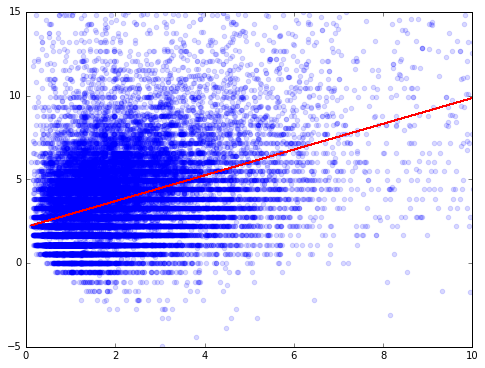

In [11]:
#distance vs. extra
plt.figure(figsize = (8,6))
plt.scatter(x, extra, color='blue', alpha = .15, label='Delay surcharge')

plt.plot(x, fit(x,extra), color='red')
plt.ylim([-5,15])
plt.xlim([0,10])

### Extra Fare vs Trip Duration


(0, 30)

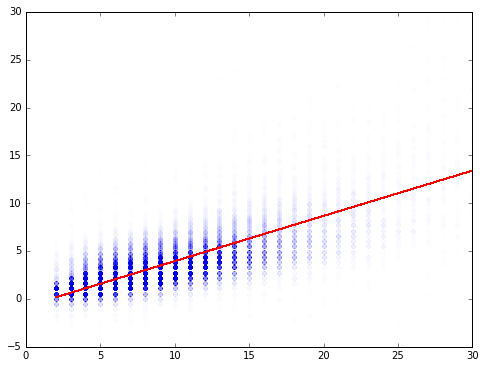

In [12]:
plt.figure(figsize = (8,6))
plt.scatter(t, extra, color='blue', alpha = .005, label='Delay surcharge')

plt.plot(t, fit(t,extra), color='red')
plt.ylim([-5,30])
plt.xlim([0,30])

## Trip Length or Trip Duration ?
Both length and duration of a trip seem to have an association with extra fares. Longer trips are more expensive. We can characterize this with a correlation coefficient. 

The functions below are introduced in data8 'correlation' and 'prediction' topics. See examples in https://data-8.appspot.com/sp16/unit?unit=5&lesson=48.

We will use the correation function to compare two variables.

In [13]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    "Compute r."
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

def slope(table, x, y):
    r = correlation(table, x, y)
    return r * np.std(table.column(y))/np.std(table.column(x))

def intercept(table, x, y):
    a = slope(table, x, y)
    return np.mean(table.column(y)) - a * np.mean(table.column(x))

print('Trip length and extra fare, r=%.3f' % correlation(nsfo_taxi, 'dist (miles)', 'extra'))

print('Trip duration and extra fare, r=%.3f' % correlation(nsfo_taxi, 'duration (min)', 'extra'))

Trip length and extra fare, r=0.327
Trip duration and extra fare, r=0.738


# Part 2.  Prediction with linear regression

The function below applies slope and intercept computations and returns these parameters of a simple linear regression y=a*x+b fit to data in a given table. 

In [14]:
def linear_coeff(table, x, y):
    """Return the regression line slope and intercept coefficients."""
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a, b

## Predictive model

Our predictive models will be using the extra fare computed with an SFMTA formula, and fitting a linear regression to the remaining extra fare. 

In [15]:
def predict_fare(table, dist):
    
    # compute parameters of a linear regression for the 'extra', as a function of distance
    a,b = linear_coeff(table, "dist (miles)", "extra")
    
    # add base fare and compute predicted 'extra'
    return base_fare(dist) + (a*dist + b)


def predict_fare_time(table, dist, tt):
    
    # compute parameters of a linear regression for the 'extra', as a function of duration
    a,b = linear_coeff(table, "duration (min)", "extra")
    
    # add base fare and compute predicted 'extra'
    return base_fare(dist) + (a*tt + b)

This is how we can use these functions.

In [16]:
d = 12.1
tt = 46.0

print('Base fare for a %.1f miles trip is: $%.1f' % (d, base_fare(d)))
print('Predicted actual fare for a %.1f miles trip is: $%.1f' % (d, predict_fare(nsfo_taxi, d)))
print('Predicted actual fare for a %.1f miles trip that takes %.1f minutes is: $%.1f' 
          % (d, tt, predict_fare_time(nsfo_taxi, d, tt)))

Base fare for a 12.1 miles trip is: $36.0
Predicted actual fare for a 12.1 miles trip is: $47.4
Predicted actual fare for a 12.1 miles trip that takes 46.0 minutes is: $56.9


## Computing predictions for a table

We can write similar functions to predict fares for a whole table. Instead of passing the length and duration arguments, we will pass the whole table_q to the prediction function. It can be the same table that is used to estimate parameters, or a *different* table containing the trips for which fares are unknown and has to be predicted.

In [17]:
def predict_fare_table(table, table_q):
    
    # compute parameters of a linear regression for the 'extra', as a function of distance
    a,b = linear_coeff(table, "dist (miles)", "extra")
     
    # add base fare and compute predicted 'extra'    
    return base_fare(table_q["dist (miles)"]) + (a*table_q["dist (miles)"] + b)

def predict_fare_table_time(table, table_q):
    
    # compute parameters of a linear regression for the 'extra', as a function of duration
    a,b = linear_coeff(table, "duration (min)", "extra") 
     
    # add base fare and compute predicted 'extra'    
    return base_fare(table_q["dist (miles)"]) + (a*table_q["duration (min)"] + b)

## Does it work? 

Let's see if our method produces accurate predictions. We are going to give it only a part of the trips (for example, first 10000) to estimate parameters, and then see if we can predict the fares for the rest of the dataset.

We will call these subset training and testing tables. 

In [18]:
# training and testing data tables
train_table = nsfo_taxi.where(nsfo_taxi["id"]<10000)
test_table = nsfo_taxi.where(nsfo_taxi["id"]>10000)

# compute predictions
pred = predict_fare_table(train_table, test_table)
pred_time = predict_fare_table_time(train_table, test_table)

### How accurate are our predictions?
We can compare our predictions with the right answers (we know them in this case sinse we partitioned the data ourselves). Let's do it with a *predicted vs observed* scatterplot.

(0, 60)

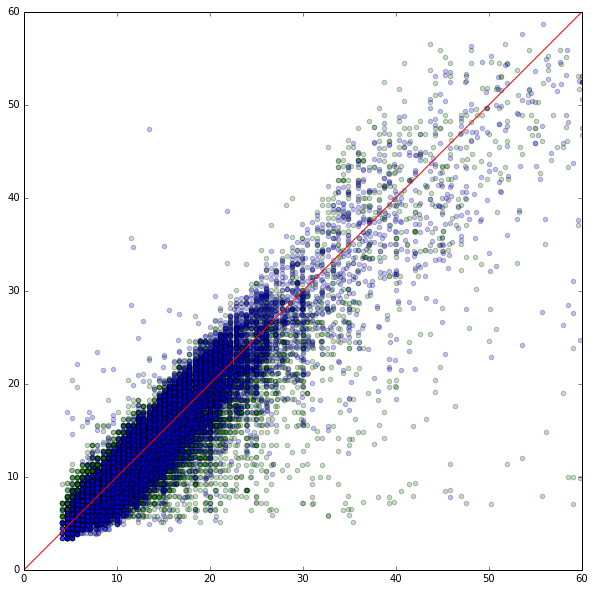

In [19]:
# plot predictions vs known (for both methods)
plt.figure(figsize = (10,10))
plt.scatter( test_table["fare ($)"], pred, c='g', alpha=0.25)
plt.scatter( test_table["fare ($)"], pred_time, c='b', alpha=0.25)
plt.plot([0, 60], [0, 60], 'red')
plt.ylim([0,60])
plt.xlim([0,60])

### Root Mean Square Error

The blue predctions look better in a scatterplot, but let's put it in numbers. We will use an RMSE to characterize how well our predictions match the observed data. 

In [20]:
def RMSE(y,yp):
    
    return np.sqrt(np.sum( (y-yp)*(y-yp) ) / len(y))

print("With distance only:", RMSE(test_table["fare ($)"], pred))
print("With distance & TT:", RMSE(test_table["fare ($)"], pred_time))

With distance only: 3.6279494619
With distance & TT: 2.58885621637


# Part 3. Wait, but trip duration is not known before the trip is taken...!

Indeed, both scatterplot and RMSE show that knowing trip duration helps a lot in predicting the fares. The problem is that it is not known before the trip is taken. One could use a routing service to get an estimated trip duration from a trustful third party.

Or... we can predict it from data too! 

Travel time within city limits will depends on the day of the week and the time of the day. Therefore our predictions will be made for each given time of day / day of week. 

In [21]:
# this function returns the parameters
def get_TT_params(table, day, hour):
    
    tb = table.where(table['day of week']==day)
    tb = tb.where(tb['start hour']==hour)
    
    a,b = linear_coeff(tb, "dist (miles)", "duration (min)")
     
    return a,b

# this fucntion returns the predictions
def predict_TT(table, dist, day, hour):
    
    tb = table.where(table['day of week']==day)
    tb = tb.where(tb['start hour']==hour)
    
    a,b = linear_coeff(tb, "dist (miles)", "duration (min)")
     
    return a*dist + b

## Explore model parameters.
Let us explore if this approch makes sense. We can look if model parameters vary throught the day/week. We are going to loop over days/hours within a week, estimate model paramaters and save them in a form of the average speed [mph].

In [22]:
ave_speed = [] # we will store results here

ind = np.arange(7*24)

hours = np.arange(0,24) # 24 hours
wdays = np.arange(0,7) # 7 days

for wday in wdays:
    for h in hours: 
    
        a, b = get_TT_params(nsfo_taxi, wday, h)
        
        ave_speed.append( 60/a ) 

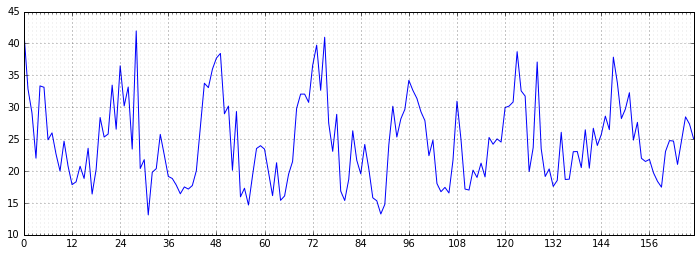

In [23]:
fig = plt.figure(figsize=(12,4))                                                               
ax = fig.add_subplot(1,1,1)  

# major ticks every 12, minor ticks every 1 hour                                      
major_ticks = np.arange(0, 24*7, 12)                                              
minor_ticks = np.arange(0, 24*7, 1)                                               

ax.set_xticks(major_ticks)                                                       
ax.set_xticks(minor_ticks, minor=True)                                           

# and a corresponding grid                                                       

ax.grid(which='both')                                                            

# or if you want differnet settings for the grids:                               
ax.grid(which='minor', alpha=0.2)                                                
ax.grid(which='major', alpha=0.75) 

ax.plot(ind, ave_speed)

### Predictions assuming trip duration is known
(same as above)

In [24]:
d = 12.1
tt = 46.0

print('Base fare for a %.1f miles trip is: $%.1f' % (d, base_fare(d)))
print('Predicted actual fare for a %.1f miles trip is: $%.1f' % (d, predict_fare(nsfo_taxi, d)))
print('Predicted actual fare for a %.1f miles trip that takes %.1f minutes is: $%.1f' 
          % (d, tt, predict_fare_time(nsfo_taxi, d, tt)))

Base fare for a 12.1 miles trip is: $36.0
Predicted actual fare for a 12.1 miles trip is: $47.4
Predicted actual fare for a 12.1 miles trip that takes 46.0 minutes is: $56.9


### Predictions of fare based on predicted trip duration

First, we predcit trip duration for a given length, if it start on a given day at a given hour.

Then, we use this travel time to predict the fare.

In [25]:
day = 1
hour = 9

TT = predict_TT(nsfo_taxi, d, day, hour)
print('Precited travel time for a %.1f miles trip on day %d at hour %d is: %.1f minutes.' % (d, day, hour, TT))

print('Predicted actual fare for this trip is: $%.1f' 
          % predict_fare_time(nsfo_taxi, d, TT))

Precited travel time for a 12.1 miles trip on day 1 at hour 9 is: 40.3 minutes.
Predicted actual fare for this trip is: $54.2


## Do predicted fares vary throughout a week?

Let's check, for a trip of given length.

In [26]:
dist = 12.0 

dfares = [] # we will store results here

ind = np.arange(7*24)

hours = np.arange(0,24) # 24 hours
wdays = np.arange(0,7) # 7 days

for wday in wdays:
    for h in hours: 
    
        TT = predict_TT(nsfo_taxi, dist, wday, h)
        ff = predict_fare_time(nsfo_taxi, dist, TT)
        
        dfares.append( ff ) 

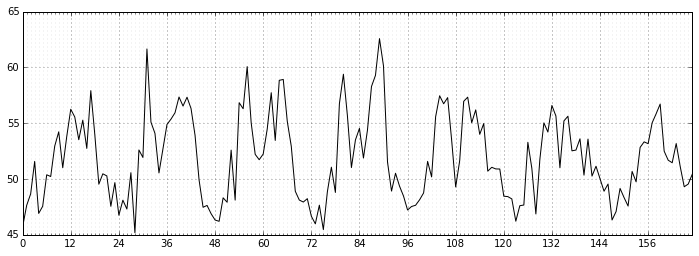

In [32]:
fig = plt.figure(figsize=(12,4))                                                               
ax = fig.add_subplot(1,1,1)  

# major ticks every 12, minor ticks every 1 hour                                      
major_ticks = np.arange(0, 24*7, 12)                                              
minor_ticks = np.arange(0, 24*7, 1)                                               

ax.set_xticks(major_ticks)                                                       
ax.set_xticks(minor_ticks, minor=True)                                           

# and a corresponding grid                                                       

ax.grid(which='both')                                                            

# or if you want differnet settings for the grids:                               
ax.grid(which='minor', alpha=0.2)                                                
ax.grid(which='major', alpha=0.75) 

ax.plot(ind, dfares, 'k')

# How accurate is our final method?

Minilab TASK: Apply the prediciton method to the test table and compare the RMSE values with the ones above. 

In [ ]:
# Code and answer